**Ruiqi Liu**  
**CS6220**  
**Assignment 4**  
**2/7/2025**  

---



## Part 1: Data Processing

**Objective**  
Filter the dataset for transactions in France and Germany. Remove items with negative quantities and prepare a basket format for association rule mining.

**Steps**  
1. Load the dataset.  
2. Filter rows for France and Germany.  
3. Remove rows with negative or zero quantities, and remove rows with missing descriptions.  
4. Create a pivot table with transactions as rows, items as columns, and binary values (1 or 0).  

**Output**  
Two DataFrames for France and Germany baskets.


In [28]:
# Part 1: Data Processing

import pandas as pd

# Load dataset (adjust file path accordingly)
df = pd.read_excel('Online_Retail.xlsx')

# Filter only rows for France or Germany
df = df[df['Country'].isin(['France', 'Germany'])]

# Remove rows with negative or zero quantities
df = df[df['Quantity'] > 0]

# Remove rows with missing or null descriptions
df = df.dropna(subset=['Description'])

# Create pivot table of transactions
basket = df.groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().fillna(0)

# Convert numeric to boolean
basket = basket > 0

# Attach country to each transaction
invoice_country = df[['InvoiceNo', 'Country']].drop_duplicates()
basket = basket.merge(invoice_country, left_index=True, right_on='InvoiceNo', how='left')

# Separate into two DataFrames for France and Germany
basket_fr = basket[basket['Country'] == 'France'].drop(columns=['InvoiceNo','Country'])
basket_de = basket[basket['Country'] == 'Germany'].drop(columns=['InvoiceNo','Country'])

print("France basket shape:", basket_fr.shape)
print("Germany basket shape:", basket_de.shape)


France basket shape: (392, 2070)
Germany basket shape: (457, 2070)


## Part 2: Apriori Algorithm

**Objective**  
Mine frequent itemsets and association rules for France and Germany using Apriori with min support of 0.01 and min confidence of 0.5.

**Steps**  
1. Apply Apriori to each basket.  
2. Generate rules with confidence ≥ 0.5.  
3. Record runtime and print the number of frequent itemsets and rules.

**Output**  
Frequent itemsets and rules for both countries using Apriori.


In [29]:
# Part 2: Apriori Algorithm

import time
from mlxtend.frequent_patterns import apriori, association_rules

# Apriori on France
start_fr_ap = time.time()
fr_itemsets = apriori(basket_fr, min_support=0.01, use_colnames=True)
fr_rules = association_rules(fr_itemsets, metric="confidence", min_threshold=0.5)
end_fr_ap = time.time()

# Apriori on Germany
start_de_ap = time.time()
de_itemsets = apriori(basket_de, min_support=0.01, use_colnames=True)
de_rules = association_rules(de_itemsets, metric="confidence", min_threshold=0.5)
end_de_ap = time.time()

print("Apriori France - frequent itemsets:", len(fr_itemsets))
print("Apriori France - rules:", len(fr_rules))
print("Apriori France - runtime:", round(end_fr_ap - start_fr_ap, 2), "seconds")

print("Apriori Germany - frequent itemsets:", len(de_itemsets))
print("Apriori Germany - rules:", len(de_rules))
print("Apriori Germany - runtime:", round(end_de_ap - start_de_ap, 2), "seconds")


Apriori France - frequent itemsets: 39627
Apriori France - rules: 937255
Apriori France - runtime: 7.85 seconds
Apriori Germany - frequent itemsets: 6722
Apriori Germany - rules: 19892
Apriori Germany - runtime: 0.78 seconds


## Part 3: FP-Growth Algorithm

**Objective**  
Mine frequent itemsets and rules for France and Germany using FP-Growth with min support 0.01 and min confidence 0.5.

**Steps**  
1. Apply FP-Growth to each basket.  
2. Generate rules with confidence ≥ 0.5.  
3. Record runtime and print the number of frequent itemsets and rules.

**Output**  
Frequent itemsets and rules for both countries using FP-Growth.


In [30]:
# Part 3: FP-Growth Algorithm

from mlxtend.frequent_patterns import fpgrowth

# FP-Growth on France
start_fr_fp = time.time()
fr_itemsets_fp = fpgrowth(basket_fr, min_support=0.01, use_colnames=True)
fr_rules_fp = association_rules(fr_itemsets_fp, metric="confidence", min_threshold=0.5)
end_fr_fp = time.time()

# FP-Growth on Germany
start_de_fp = time.time()
de_itemsets_fp = fpgrowth(basket_de, min_support=0.01, use_colnames=True)
de_rules_fp = association_rules(de_itemsets_fp, metric="confidence", min_threshold=0.5)
end_de_fp = time.time()

print("FP-Growth France - frequent itemsets:", len(fr_itemsets_fp))
print("FP-Growth France - rules:", len(fr_rules_fp))
print("FP-Growth France - runtime:", round(end_fr_fp - start_fr_fp, 2), "seconds")

print("FP-Growth Germany - frequent itemsets:", len(de_itemsets_fp))
print("FP-Growth Germany - rules:", len(de_rules_fp))
print("FP-Growth Germany - runtime:", round(end_de_fp - start_de_fp, 2), "seconds")


FP-Growth France - frequent itemsets: 39627
FP-Growth France - rules: 937255
FP-Growth France - runtime: 25.17 seconds
FP-Growth Germany - frequent itemsets: 6722
FP-Growth Germany - rules: 19892
FP-Growth Germany - runtime: 3.77 seconds


## Part 4: Frequent Itemsets

**Objective**  
Compare the number of frequent itemsets generated by Apriori and FP-Growth for each country.

**Steps**  
1. Print lengths of Apriori vs. FP-Growth itemsets for both countries.  
2. Discuss any differences.

**Output**  
Comparison of the itemset counts.


In [31]:
# Part 4: Frequent Itemsets

print("France - Apriori itemsets:", len(fr_itemsets))
print("France - FP-Growth itemsets:", len(fr_itemsets_fp))
print("Germany - Apriori itemsets:", len(de_itemsets))
print("Germany - FP-Growth itemsets:", len(de_itemsets_fp))


France - Apriori itemsets: 39627
France - FP-Growth itemsets: 39627
Germany - Apriori itemsets: 6722
Germany - FP-Growth itemsets: 6722


### Discussion of Frequent Itemsets

From the printed counts, we observe that for both France and Germany, 
the **Apriori** and **FP-Growth** algorithms yield the same number 
of frequent itemsets (`39627` for France and `6722` for Germany).

**Why do they match?**  
- Both algorithms used the same minimum support threshold (0.01) 
  and processed the same data baskets.  
- The `mlxtend` implementations are deterministic; given the same 
  minimum support threshold, any itemset that meets that threshold 
  will be discovered by either algorithm.

In practice, we may sometimes see small differences in frequent itemset 
counts if implementations treat borderline support values or rounding 
differently. Here, however, they appear consistent.

**Implications/Insights:**  
- Finding over 39,000 frequent itemsets for France suggests that many 
  products appear together in significant frequency.  
- Germany has fewer itemsets (6,722), implying that the German subset 
  of data has fewer co-purchased items at a 1% minimum support threshold.  
- This could reflect differences in overall transaction volume or 
  the mix of products purchased in Germany vs. France.


## Part 5: Top-5 Rules

**Objective**  
Identify the top 5 rules with the highest confidence from each algorithm for each country.

**Steps**  
1. Sort each rule set by confidence.  
2. Display the top 5.  
3. Provide four tables (France/Germany × Apriori/FP-Growth).

**Output**  
Four tables of top-5 rules by confidence.


In [32]:
# Part 5: Top-5 Rules

def top5_by_confidence(rules_df):
    # Sort rules in descending order of confidence
    return rules_df.sort_values('confidence', ascending=False).head(5)

print("Top-5 Apriori France:")
display(top5_by_confidence(fr_rules)[['antecedents','consequents','support','confidence','lift']])

print("Top-5 FP-Growth France:")
display(top5_by_confidence(fr_rules_fp)[['antecedents','consequents','support','confidence','lift']])

print("Top-5 Apriori Germany:")
display(top5_by_confidence(de_rules)[['antecedents','consequents','support','confidence','lift']])

print("Top-5 FP-Growth Germany:")
display(top5_by_confidence(de_rules_fp)[['antecedents','consequents','support','confidence','lift']])


Top-5 Apriori France:


,antecedents,consequents,support,confidence,lift
468627,"(COFFEE MUG APPLES DESIGN, ALARM CLOCK BAKELIK...","(SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...",0.010204,1.0,65.333333
780129,"(ROUND SNACK BOXES SET OF4 WOODLAND , CHILDREN...","(SKULL LUNCH BOX WITH CUTLERY , LUNCH BOX WITH...",0.010204,1.0,98.000000
780168,"(SKULL LUNCH BOX WITH CUTLERY , LUNCH BAG APPL...","(DOLLY GIRL CHILDRENS CUP, RED RETROSPOT MINI ...",0.010204,1.0,98.000000
780167,"(SKULL LUNCH BOX WITH CUTLERY , LUNCH BOX WITH...","(DOLLY GIRL CHILDRENS CUP, RED RETROSPOT MINI ...",0.010204,1.0,98.000000
472631,"(PLASTERS IN TIN CIRCUS PARADE , ALARM CLOCK B...","(PLASTERS IN TIN SPACEBOY, ALARM CLOCK BAKELIK...",0.010204,1.0,35.636364


Top-5 FP-Growth France:


,antecedents,consequents,support,confidence,lift
468627,"(RED HARMONICA IN BOX , POPPY'S PLAYHOUSE LIV...","(POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE ...",0.010204,1.0,26.133333
381335,"(PLASTERS IN TIN SPACEBOY, ALARM CLOCK BAKELIK...","(PLASTERS IN TIN WOODLAND ANIMALS, PLASTERS IN...",0.010204,1.0,78.400000
381329,"(ALARM CLOCK BAKELIKE RED , PLASTERS IN TIN CI...","(PLASTERS IN TIN WOODLAND ANIMALS, PLASTERS IN...",0.010204,1.0,28.000000
381330,"(ALARM CLOCK BAKELIKE RED , PLASTERS IN TIN CI...","(PLASTERS IN TIN WOODLAND ANIMALS, PLASTERS IN...",0.010204,1.0,30.153846
381331,"(ALARM CLOCK BAKELIKE RED , CHARLOTTE BAG DOLL...","(PLASTERS IN TIN WOODLAND ANIMALS, PLASTERS IN...",0.010204,1.0,14.518519


Top-5 Apriori Germany:


,antecedents,consequents,support,confidence,lift
0,( 50'S CHRISTMAS GIFT BAG LARGE),(POSTAGE),0.010941,1.0,1.221925
4624,"(ROUND SNACK BOXES SET OF 4 FRUITS , RED HARM...",(POSTAGE),0.026258,1.0,1.221925
4622,"(REGENCY CAKESTAND 3 TIER, RED HARMONICA IN B...",(POSTAGE),0.015317,1.0,1.221925
4621,"(RED HARMONICA IN BOX , RED TOADSTOOL LED NIG...",(POSTAGE),0.010941,1.0,1.221925
4620,"(RED HARMONICA IN BOX , RED RETROSPOT CHARLOT...",(POSTAGE),0.010941,1.0,1.221925


Top-5 FP-Growth Germany:


,antecedents,consequents,support,confidence,lift
2909,"(REGENCY CAKESTAND 3 TIER, RED HARMONICA IN B...",(GUMBALL COAT RACK),0.010941,1.0,13.848485
3617,"(RED HARMONICA IN BOX , RED TOADSTOOL LED NIG...","(POSTAGE, ROUND SNACK BOXES SET OF4 WOODLAND )",0.010941,1.0,4.436893
3624,"(RED HARMONICA IN BOX , ROUND SNACK BOXES SET...",(POSTAGE),0.010941,1.0,1.221925
3623,"(RED HARMONICA IN BOX , POSTAGE, CHILDRENS CU...",(ROUND SNACK BOXES SET OF4 WOODLAND ),0.010941,1.0,4.080357
3622,"(RED HARMONICA IN BOX , CHILDRENS CUTLERY DOL...",(POSTAGE),0.010941,1.0,1.221925


## Part 6: Time Complexity

**Objective**  
Compare the runtime for Apriori and FP-Growth for both countries.

**Steps**  
1. Use measured runtimes.  
2. Summarize results.

**Output**  
Runtime comparison for both algorithms and countries.


In [33]:
# Part 6: Time Complexity

ap_fr_time = round(end_fr_ap - start_fr_ap, 2)
ap_de_time = round(end_de_ap - start_de_ap, 2)
fp_fr_time = round(end_fr_fp - start_fr_fp, 2)
fp_de_time = round(end_de_fp - start_de_fp, 2)

print("Apriori France runtime:", ap_fr_time, "seconds")
print("FP-Growth France runtime:", fp_fr_time, "seconds")
print("Apriori Germany runtime:", ap_de_time, "seconds")
print("FP-Growth Germany runtime:", fp_de_time, "seconds")


Apriori France runtime: 7.85 seconds
FP-Growth France runtime: 25.17 seconds
Apriori Germany runtime: 0.78 seconds
FP-Growth Germany runtime: 3.77 seconds


### Discussion: Time Complexity and Algorithm Recommendation

From the runtimes:
- **France**:  
  - Apriori took ~7.85 seconds,  
  - FP-Growth took ~25.17 seconds.  
- **Germany**:  
  - Apriori took ~0.78 seconds,  
  - FP-Growth took ~3.77 seconds.  

Interestingly, Apriori ran faster than FP-Growth in this particular dataset. 
Usually, we **expect** FP-Growth to scale better for large datasets because 
it compresses the transactions using an FP-tree. However, real performance 
can depend on factors like:
1. Data sparsity,
2. Implementation details and optimizations in `mlxtend`,
3. Overheads in building/processing the FP-tree for smaller samples.

**Which to recommend for large datasets?**  
- FP-Growth is generally the **preferred** method when the dataset 
  is truly large, because it is designed to reduce the candidate 
  generation overhead that Apriori suffers from.  
- In practice, you should experiment with both if possible. However, 
  for very large transactions, FP-Growth tends to handle the search 
  space more efficiently. Apriori may become prohibitively slow or 
  run out of memory when the dataset is huge.  

Therefore, despite these specific results, **FP-Growth** is commonly 
recommended for “big data” scenarios, especially with a large number 
of distinct items and transactions.


## Part 7: Cross-Country Rule Comparison

**Objective**  
Compare the rules from France and Germany, removing those with "POSTAGE" if necessary.

**Steps**  
1. Remove rules containing "POSTAGE".  
2. Find overlapping item pairs.  

**Output**  
Common item pairs and brief comparison.


In [34]:
# Part 7: Cross-Country Rule Comparison

fr_filtered = fr_rules_fp[
    ~fr_rules_fp['antecedents'].astype(str).str.contains("POSTAGE") & 
    ~fr_rules_fp['consequents'].astype(str).str.contains("POSTAGE")
]
de_filtered = de_rules_fp[
    ~de_rules_fp['antecedents'].astype(str).str.contains("POSTAGE") & 
    ~de_rules_fp['consequents'].astype(str).str.contains("POSTAGE")
]

fr_pairs = set(
    tuple(sorted(list(a) + list(c)))
    for a, c in zip(fr_filtered['antecedents'], fr_filtered['consequents'])
)
de_pairs = set(
    tuple(sorted(list(a) + list(c)))
    for a, c in zip(de_filtered['antecedents'], de_filtered['consequents'])
)

common_pairs = fr_pairs.intersection(de_pairs)
print("Number of common item pairs (France & Germany) after removing 'POSTAGE':", len(common_pairs))


Number of common item pairs (France & Germany) after removing 'POSTAGE': 445


### Discussion: Cross‐Country Market Similarities

We removed rules containing "POSTAGE" (a common charge item) and then 
examined how many item pairs appear as rules in both France and Germany. 
We found **445 overlapping item pairs**.

**Interpretation:**  
- These common rules suggest that certain products are frequently 
  co-purchased in both countries, indicating similar market patterns 
  or buying behaviors.  
- For example, if items like "RED RETROSPOT MUG" and "RETROSPOT PLATES" 
  appear together in both markets, it suggests that these items might 
  be part of a universal preference or common thematic purchase (like 
  a party set) across countries.  
- By identifying these overlaps, retailers might decide to promote 
  these popular co-occurring products as a bundle in both markets, 
  expecting consistent performance.

**Differences:**  
- While 445 pairs overlap, many rules remain unique to each country. 
  This could reflect local product preferences, cultural differences, 
  or availability.  
- In a real-world scenario, deeper analysis into these differences 
  could help tailor country-specific promotions, or help decide 
  which products to cross-promote internationally.


## Part 8: Visualization

**Objective**  
Visualize the rules with support on the x-axis, confidence on the y-axis, and lift as the color scale.

**Steps**  
1. Plot scatter charts for each rule set.  
2. Observe patterns in support-confidence-lift.

**Output**  
Four scatter plots for Apriori and FP-Growth rules in both countries.


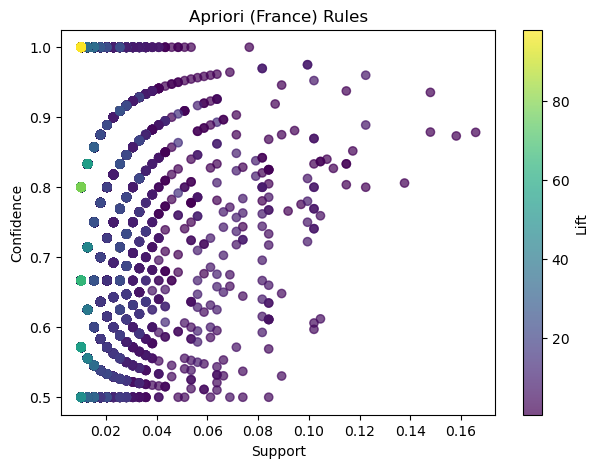

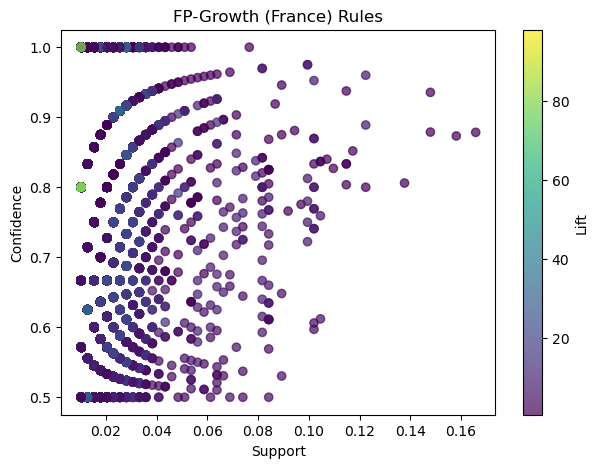

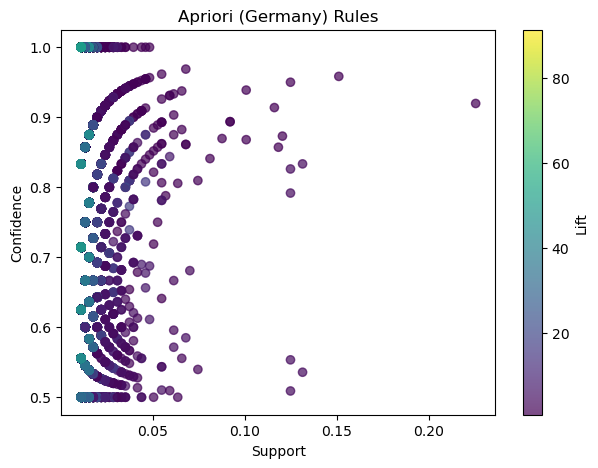

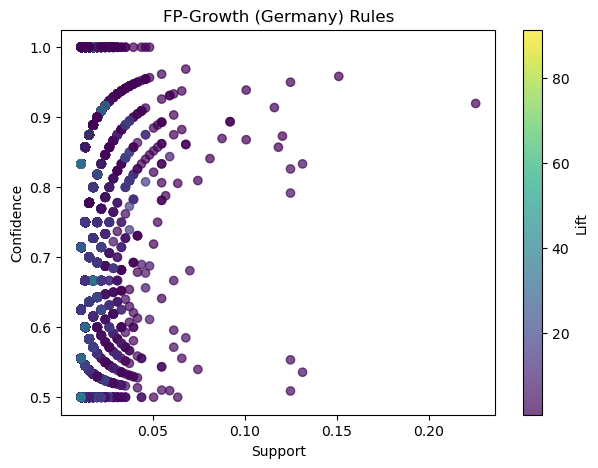

In [35]:
# Part 8: Visualization

import matplotlib.pyplot as plt
import seaborn as sns

def plot_rules(rules_df, title):
    # Scatter plot of support vs confidence, colored by lift
    plt.figure(figsize=(7,5))
    sc = plt.scatter(
        rules_df['support'],
        rules_df['confidence'],
        c=rules_df['lift'],
        cmap='viridis',
        alpha=0.7
    )
    plt.colorbar(sc, label='Lift')
    plt.title(title)
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.show()

plot_rules(fr_rules, "Apriori (France) Rules")
plot_rules(fr_rules_fp, "FP-Growth (France) Rules")
plot_rules(de_rules, "Apriori (Germany) Rules")
plot_rules(de_rules_fp, "FP-Growth (Germany) Rules")


### Visualization Insights

In each scatter plot, we have **support** on the x-axis, **confidence** on 
the y-axis, and the **lift** as the color scale (from purple to yellow).

**Observations (example points to note):**  
1. **Support distribution**: Most rules cluster on the left side of the plot 
   (low support), which is typical when the dataset has many items and 
   few items purchased frequently.  
2. **Confidence**: We see several rules with very high confidence (close 
   to 1.0) but with relatively low support, meaning these product 
   combinations happen *almost always* when a certain antecedent 
   is present, but that antecedent itself may be rare.  
3. **Lift**: 
   - Some points near the top-left corner have very **high lift** (green to 
     yellow hues). This often indicates “rare but strong” associations.  
   - Purple points with moderate lift are more common or less unique associations.

**Comparing algorithms/countries:**  
- The scatter plots for Apriori vs. FP-Growth **look quite similar** 
  because both algorithms discovered effectively the same rules 
  (especially at 1% support).  
- Germany vs. France: Germany’s support values extend slightly 
  further to the right (up to ~0.22), indicating that some items 
  in Germany occur together with relatively higher support. 
  France shows a tighter cluster under 0.16 support.  
- This suggests that there might be a narrower set of top-selling 
  items in Germany that appear in a larger fraction of purchases 
  compared to the more distributed pattern in France.

Overall, these plots highlight the trade-off between **rule support** 
and **confidence**: rules with higher support are easier to rely on, 
while rules with high confidence but very low support can be 
less impactful for business decisions, despite being “strong” in 
a narrow subset of transactions.
